<a href="https://colab.research.google.com/github/tankTopTaro/Deep-Learning-with-Python/blob/main/08_Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing

NLP has the goal of deriving information out of natural language (could be sequences of text or speech).
Another common term for NLP problems is sequence to sequence problems (seq2seq).

In [1]:
## Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fb0be16f-7be1-0834-9cf8-ce18f7a615a9)


In [2]:
## Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

## Import series of functions for this notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-11-08 19:00:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-08 19:00:43 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

See the original source here: https://www.kaggle.com/competitions/nlp-getting-started

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

## Unzip data
unzip_data('nlp_getting_started.zip')

--2022-11-08 19:00:46--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-11-08 19:00:46 (119 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

Another way to this is to use pandas: https://realpython.com/pandas-read-write-files/

In [4]:
## Read in .csv files with pandas read_csv
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [7]:
## Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
## What does the test dataframe look like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
## How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
## How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [11]:
## Visualize random training examples
import random

rand_index = random.randint(0, len(train_df)-5) # Create random indices not higher from the total number of train data

for row in train_df_shuffled[['text', 'target']][rand_index:rand_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Because you watched: Honey I Blew up the Economy

We Recommend : The Conservative Shoppe of Horrors

#HarperANetflixShow #elxn42 #stopharper

---

Target: 1 (real disaster)
Text:
Islamic State group threatens to kill hostage if Û÷Muslim womenÛª arenÛªt let go - http://t.co/48Zg5ynebn...

---

Target: 0 (not real disaster)
Text:
?that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time

---

Target: 0 (not real disaster)
Text:
@KalinAndMyles @KalinWhite my ig is being blown up just with hackers I need it to stop #givebackkalinwhiteaccount

---

Target: 0 (not real disaster)
Text:
@blizzard_fans Lucio!! Let's get the #overwatch hype train rolling some more!! Caution though there aren't any breaks

---



## Splitting data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
## Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled['text'].to_numpy(),
    train_df_shuffled['target'].to_numpy(),
    test_size=0.1, # use 10% of training data for validation
    random_state=42
)

In [14]:
## Check the lengths
print(f"train_sentences: {len(train_sentences)}")
print(f"train_labels: {len(train_labels)}")
print(f"val_sentences: {len(val_sentences)}")
print(f"val_labels: {len(val_labels)}")

train_sentences: 6851
train_labels: 6851
val_sentences: 762
val_labels: 762


In [15]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text data to numbers using Tokenization and Embeddings

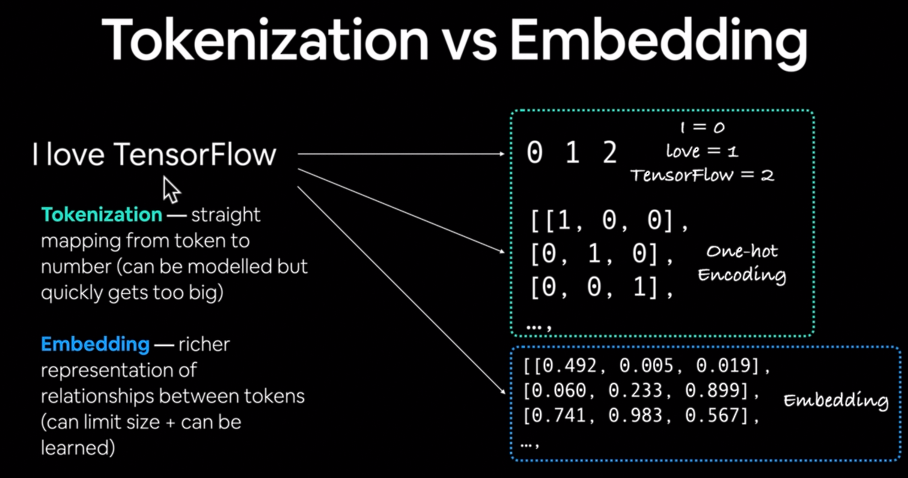

In [16]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

## Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None, # create groups of n-words?
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want sequences to be?
                                    pad_to_max_tokens=False) # can be set to TRUE if max_tokens has value

In [18]:
## Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [19]:
## Setup text vectorization variables
max_vocab_length = 10000    # max number of words to have in our vocabulary
max_length = 15   # max length our sequences will be

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [20]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [21]:
## Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
## Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
## Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/sW1sBua3mN via @Change        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  69,  372, 1001,  327, 1578,  372,  188,  240,    2,  796,    6,
           2, 1180,  499,  250]])>

In [24]:
## Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5]  # get most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Create an Embedding using an [Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector (e.g. a value of 100 would mean each token gets represented by a vector 100 long)
* `input_length` = length of the sequences being passed to the embedding layer

In [25]:
from tensorflow.keras import layers

In [26]:
embedding = layers.Embedding(input_dim=max_vocab_length,  # set input shape
                             output_dim=128,  # set output shape
                             embeddings_initializer='uniform',
                             input_length=max_length) # how long is each input

embedding

In [27]:
## Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
        \n\nEmbedded version:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@JoseBasedGod I'm obliterate you to the shadow realm.        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01086516,  0.02569494,  0.00854   , ...,  0.01566744,
          0.02034536, -0.03279014],
        [-0.04975149, -0.04533515,  0.03155812, ..., -0.00645981,
          0.01835325,  0.03452072],
        [-0.00072541,  0.02480889,  0.00351992, ...,  0.02432476,
         -0.01457804, -0.03178493],
        ...,
        [-0.01452054, -0.02203823, -0.01901865, ..., -0.02369053,
          0.0463458 , -0.03232695],
        [-0.01452054, -0.02203823, -0.01901865, ..., -0.02369053,
          0.0463458 , -0.03232695],
        [-0.01452054, -0.02203823, -0.01901865, ..., -0.02369053,
          0.0463458 , -0.03232695]]], dtype=float32)>

In [28]:
## Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01086516,  0.02569494,  0.00854   ,  0.04962692, -0.00857483,
        -0.00728309,  0.02292093,  0.04021832, -0.02750597,  0.00329387,
         0.04033205,  0.02469548,  0.03360072, -0.04681311,  0.04543377,
        -0.00980484, -0.02216261, -0.00684966, -0.02940427,  0.0230363 ,
        -0.00330615, -0.01726871, -0.03200638,  0.01399067, -0.03799243,
        -0.00168561, -0.01516334, -0.01788204,  0.01105642,  0.00725085,
         0.04251368, -0.00884927, -0.04529136,  0.01831534,  0.02828843,
         0.02572215, -0.04501912, -0.04844122, -0.01318278, -0.02557777,
         0.02561072,  0.04668415, -0.02164372,  0.03142099,  0.01353021,
        -0.02555277, -0.02681546,  0.01759573, -0.00948343,  0.02401144,
         0.02487649,  0.01042043,  0.01731103,  0.04700467,  0.01650376,
         0.02994057, -0.02207481, -0.03166237,  0.0095263 , -0.01113685,
        -0.01647831,  0.03583718,  0.02317368, -0.04756234,  0.01179665,
  

## Modelling a text dataset (running a series of experiments)

* Model 0: Naive Bayes (baseline), this is from [SKLearn ML map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

### Model 0: Getting a baseline

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Create tokenization and modelling pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),   # convert words to numbers using tfidf
    ('clf', MultinomialNB())  # model the text
])

## Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
## Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [31]:
## Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function

> For a deep overview of many different evaluation methods, see SKlearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html


In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.
  """
  ## Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  ## Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  
  return model_results

In [33]:
## Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [34]:
## Create a tensorboard callback
from helper_functions import create_tensorboard_callback

## Create a directory to save TensorBoard logs
SAVE_DIR = 'model_logs'

In [35]:
## Build model with Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turns the input text into numbers
x = embedding(x)  # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation='sigmoid')(x)  # create the output layer
model_1 = tf.keras.Model(inputs, outputs, name='model_1_dense')


In [36]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [37]:
## Compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
## Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20221108-190050
Epoch 1/5
215/215 [==============================] - 5s 9ms/step - loss: 0.6140 - accuracy: 0.6879 - val_loss: 0.5369 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4434 - accuracy: 0.8178 - val_loss: 0.4693 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3480 - accuracy: 0.8603 - val_loss: 0.4547 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2850 - accuracy: 0.8915 - val_loss: 0.4640 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2385 - accuracy: 0.9134 - val_loss: 0.4748 - val_accuracy: 0.7835


In [39]:
## Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4748 - accuracy: 0.7835


[0.474779337644577, 0.7834645509719849]

In [40]:
## Make some predictions and evaluate
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 4ms/step


(762, 1)

In [41]:
## Look at a single prediction
model_1_pred_probs[0]

array([0.35489902], dtype=float32)

In [42]:
## Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.35489902],
       [0.75290614],
       [0.9975556 ],
       [0.12019567],
       [0.12898706],
       [0.93432665],
       [0.8898551 ],
       [0.9932166 ],
       [0.96229583],
       [0.27649036]], dtype=float32)

In [43]:
## Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [44]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels, model_1_preds)
print(f"model_1\n {model_1_results}")
print(f"baseline\n {baseline_results}")

model_1
 {'accuracy': 78.34645669291339, 'precision': 0.7872123378365872, 'recall': 0.7834645669291339, 'f1': 0.7807800582578167}
baseline
 {'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


In [45]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [46]:
## Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [47]:
## Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [48]:
## Get the weight matrix of embedding layer
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape)  # same size as vocab size and embedding_dim

(10000, 128)


TensorFlow Projector: https://projector.tensorflow.org/

Word Embeddings Documentation: https://www.tensorflow.org/text/guide/word_embeddings

In [49]:
## Create embedding files
# import io

# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#  if index == 0:
#    continue  # skip 0, it's padding.
#  vec = embed_weights[index]
#  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#  out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [50]:
## Download file from Colab to upload to 

# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input

> 📖**Resources:**
>
>
> *   MIT's sequence modelling lecture: https://youtu.be/QvkQ1B3FBqA?list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&t=616
> *   Chris Olah's intro to LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
> *   Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/



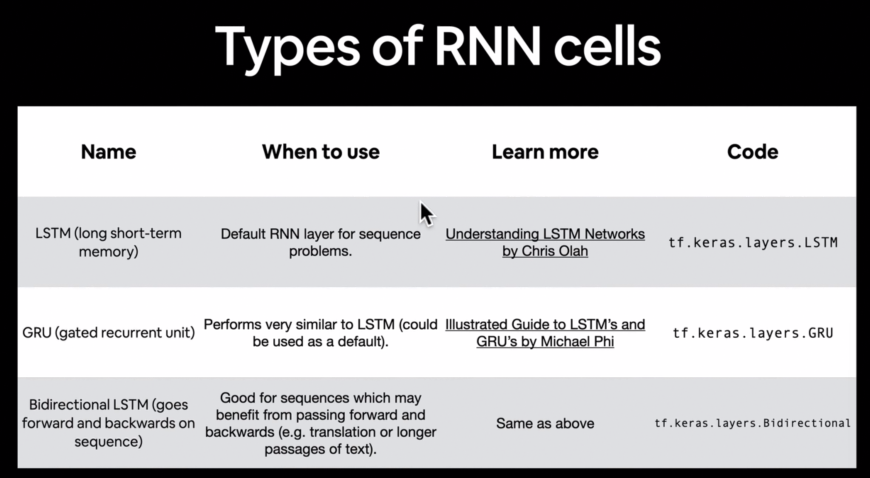


### Model 2: [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

LSTM > long short term memory

Typical structure of an RNN:

  `INPUT (text) -> TOKENIZE -> EMBEDDING -> LAYERS (RNNs/dense) ->OUTPUT (label probability)`

In [51]:
## Create an LSTM model
from keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x)   
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [52]:
## Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [53]:
## Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [54]:
## Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20221108-190104
Epoch 1/5
215/215 [==============================] - 12s 18ms/step - loss: 0.2211 - accuracy: 0.9232 - val_loss: 0.5387 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1565 - accuracy: 0.9425 - val_loss: 0.6803 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1297 - accuracy: 0.9520 - val_loss: 0.6821 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1072 - accuracy: 0.9561 - val_loss: 0.8022 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0844 - accuracy: 0.9675 - val_loss: 0.9069 - val_accuracy: 0.7756


In [55]:
## Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[7.6398384e-03],
       [7.8900397e-01],
       [9.9949992e-01],
       [3.2276623e-02],
       [5.2975258e-04],
       [9.9686795e-01],
       [5.7477969e-01],
       [9.9978012e-01],
       [9.9963081e-01],
       [3.4128729e-01]], dtype=float32)

In [56]:
## Convert model 2 prediction probabilities to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [57]:
## Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
print(model_2_results)
print(baseline_results)

{'accuracy': 77.55905511811024, 'precision': 0.7802047087708873, 'recall': 0.7755905511811023, 'f1': 0.7723569237171506}
{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 3: [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)

In [58]:
## Build an RNN using GRU cell
from keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True)(x) # set 'return_sequences' to True if you want to stack recurrent layers
# x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [59]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [60]:
## Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [61]:
## Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20221108-190130
Epoch 1/5
215/215 [==============================] - 4s 9ms/step - loss: 0.1587 - accuracy: 0.9374 - val_loss: 0.7399 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0816 - accuracy: 0.9701 - val_loss: 0.8887 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0718 - accuracy: 0.9736 - val_loss: 0.8716 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0606 - accuracy: 0.9745 - val_loss: 1.0307 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0543 - accuracy: 0.9768 - val_loss: 1.0344 - val_accuracy: 0.7717


In [62]:
## Make predictions with the GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[5.3131375e-03],
       [8.4741700e-01],
       [9.9988651e-01],
       [8.8773027e-02],
       [1.9537659e-04],
       [9.9963987e-01],
       [7.9564440e-01],
       [9.9995768e-01],
       [9.9988866e-01],
       [8.4684741e-01]], dtype=float32)

In [63]:
## Convert predictions into labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [64]:
## Calculate results
model_3_results = calculate_results(val_labels, model_3_preds)
print(model_3_results)
print(baseline_results)

{'accuracy': 77.16535433070865, 'precision': 0.7724094757924029, 'recall': 0.7716535433070866, 'f1': 0.7700698633249685}
{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 4: [Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [65]:
## Build a bidirectional RNN
from keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [66]:
## Get summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [67]:
## Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [68]:
## Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20221108-190141
Epoch 1/5
215/215 [==============================] - 6s 12ms/step - loss: 0.1111 - accuracy: 0.9670 - val_loss: 1.0047 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0535 - accuracy: 0.9784 - val_loss: 1.0033 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0481 - accuracy: 0.9787 - val_loss: 1.1821 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0458 - accuracy: 0.9791 - val_loss: 1.0795 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0480 - accuracy: 0.9780 - val_loss: 1.3176 - val_accuracy: 0.7625


In [69]:
## Make predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[2.3836799e-01],
       [9.0456849e-01],
       [9.9997175e-01],
       [2.9431865e-01],
       [4.3715689e-05],
       [9.9987340e-01],
       [9.0920192e-01],
       [9.9998665e-01],
       [9.9997866e-01],
       [9.7456658e-01]], dtype=float32)

In [70]:
## Convert predictions into labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [71]:
## Calculate results
model_4_results = calculate_results(val_labels, model_4_preds)
print(model_4_results)
print(baseline_results)

{'accuracy': 76.24671916010499, 'precision': 0.7620575258370533, 'recall': 0.7624671916010499, 'f1': 0.7619644727220641}
{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


## Convulotion Neural Network for Text (and other types of sequences)

Typical structure of a Conv1D model for sequences:

`INPUTS (text) -> TOKENIZATION -> EMBEDDING -> LAYER(S) (typically Conv1D + pooling) -> OUTPUTS (class probabilities)`

### Model 5: Conv1D

In [72]:
## Test out our embedding layer, Convv1D layer and max pooling
from keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))  # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation='relu',
                        padding='valid')
conv_1d_output = conv_1d(embedding_test)  # past test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)  # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [73]:
## Build a 1D CNN for text
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation='relu',
                  padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

In [74]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [75]:
## Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [76]:
## Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_5_conv1d')])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20221108-190209
Epoch 1/5
215/215 [==============================] - 3s 7ms/step - loss: 0.1205 - accuracy: 0.9600 - val_loss: 0.9093 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0743 - accuracy: 0.9729 - val_loss: 1.0166 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0614 - accuracy: 0.9756 - val_loss: 1.1120 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0541 - accuracy: 0.9778 - val_loss: 1.1681 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0495 - accuracy: 0.9794 - val_loss: 1.1941 - val_accuracy: 0.7546


In [77]:
## Make predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[2.3929416e-01],
       [6.3471305e-01],
       [9.9993038e-01],
       [8.0683738e-02],
       [9.8244826e-08],
       [9.9418169e-01],
       [9.4810510e-01],
       [9.9996877e-01],
       [9.9999964e-01],
       [9.1872388e-01]], dtype=float32)

In [78]:
## Convert predictions into labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [79]:
## Evaluate model 5 predictions
model_5_results = calculate_results(val_labels, model_5_preds)
print(model_5_results)
print(baseline_results)

{'accuracy': 75.45931758530183, 'precision': 0.7547954838468575, 'recall': 0.7545931758530183, 'f1': 0.7530724049375026}
{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 6: **[USE](https://tfhub.dev/google/universal-sentence-encoder/4)** *([Universal Sentence Encoder](https://arxiv.org/abs/1803.11175))* Feature Extractor

In [80]:
import tensorflow_hub as hub

embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [81]:
embed_samples[0].shape

TensorShape([512])

In [82]:
## Create Keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [83]:
## Create model using Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output')
], name='model_6_USE')

## Compile
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [84]:
## Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20221108-190253
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5065 - accuracy: 0.7860 - val_loss: 0.4484 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4146 - accuracy: 0.8158 - val_loss: 0.4389 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4006 - accuracy: 0.8213 - val_loss: 0.4312 - val_accuracy: 0.8176
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3925 - accuracy: 0.8276 - val_loss: 0.4333 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3857 - accuracy: 0.8273 - val_loss: 0.4280 - val_accuracy: 0.8150


In [85]:
## Make predictions with USE model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.17541029],
       [0.7694746 ],
       [0.98949873],
       [0.21653922],
       [0.729115  ],
       [0.7519661 ],
       [0.97850776],
       [0.9777004 ],
       [0.9542799 ],
       [0.10113339]], dtype=float32)

In [86]:
## Convert predictions into labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [87]:
## Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
print(model_6_results)
print(baseline_results)

{'accuracy': 81.49606299212599, 'precision': 0.8172549323109193, 'recall': 0.8149606299212598, 'f1': 0.8134357776936025}
{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


### Model 7: TF Hub Pretrained USE but with 10% of training data

In [88]:
## NOTE: Making data splits like below leads to data leakage (model 7 trained on 10% data outperforms model 6 trained on 100%)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VAVLIDATION/TEST SETS INTO TRAINING SET

## Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [89]:
 ## Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [90]:
## Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [91]:
## Check the number of targets in our subset of data
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [92]:
## Create a model trained on 10 percent of training data
# model_7 = tf.keras.models.clone_model(model_6)

model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_7_USE_10_percent')

model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_7_USE_10_percent = model_7.fit(train_sentences_10_percent,
                                     train_labels_10_percent,
                                     epochs=5,
                                     validation_data=(val_sentences, val_labels),
                                     callbacks=[create_tensorboard_callback(SAVE_DIR, 'tf_hub_sentence_encoder_10_percent_correct_split')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20221108-190316
Epoch 1/5
22/22 [==============================] - 2s 46ms/step - loss: 0.6655 - accuracy: 0.6759 - val_loss: 0.6458 - val_accuracy: 0.6969
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5940 - accuracy: 0.7985 - val_loss: 0.5868 - val_accuracy: 0.7533
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5189 - accuracy: 0.8175 - val_loss: 0.5346 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4589 - accuracy: 0.8307 - val_loss: 0.5058 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4200 - accuracy: 0.8365 - val_loss: 0.4937 - val_accuracy: 0.7743


In [93]:
## Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.20123264],
       [0.5658069 ],
       [0.90961826],
       [0.36249223],
       [0.5515446 ],
       [0.6785788 ],
       [0.86678696],
       [0.78108305],
       [0.8410374 ],
       [0.14310618]], dtype=float32)

In [94]:
## Turn predictions into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [95]:
## Evaluate model 7 predictions
model_7_results = calculate_results(val_labels, model_7_preds)
print(model_7_results)
print(model_6_results)
print(baseline_results)

{'accuracy': 77.42782152230971, 'precision': 0.7762579677540307, 'recall': 0.7742782152230971, 'f1': 0.7721023076072874}
{'accuracy': 81.49606299212599, 'precision': 0.8172549323109193, 'recall': 0.8149606299212598, 'f1': 0.8134357776936025}
{'accuracy': 79.26509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


## Comparing the performance of each of our models

In [96]:
## Combine model results into a DataFrame
all_model_results = pd.DataFrame({'0_baseline': baseline_results,
                                 '1_simple_dense': model_1_results,
                                 '2_lstm': model_2_results,
                                 '3_gru': model_3_results,
                                 '4_bidirectonal': model_4_results,
                                 '5_conv1d': model_5_results,
                                 '6_tf_hub_use_encoder': model_6_results,
                                 '7_tf_hub_use_encoder_10_percent': model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.787212,0.783465,0.780780
2_lstm,77.559055,0.780205,0.775591,0.772357
3_gru,77.165354,0.772409,0.771654,0.770070
4_bidirectonal,76.246719,0.762058,0.762467,0.761964
5_conv1d,75.459318,0.754795,0.754593,0.753072
6_tf_hub_use_encoder,81.496063,0.817255,0.814961,0.813436
7_tf_hub_use_encoder_10_percent,77.427822,0.776258,0.774278,0.772102


In [97]:
## Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
# all_model_results

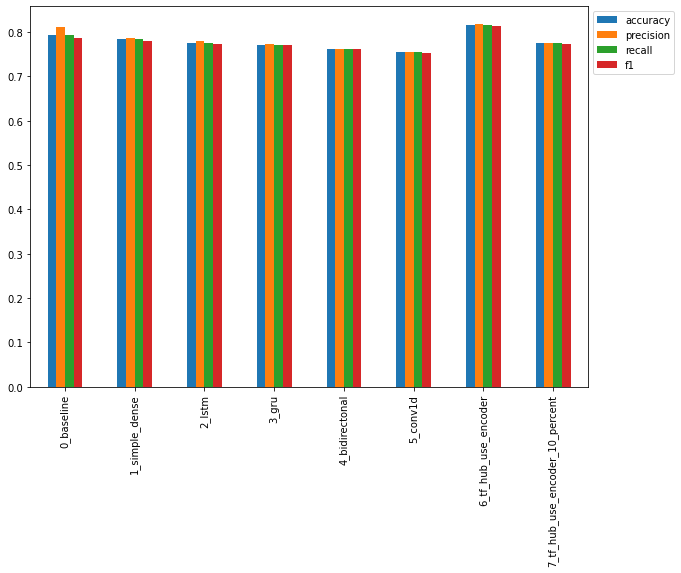

In [98]:
## Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

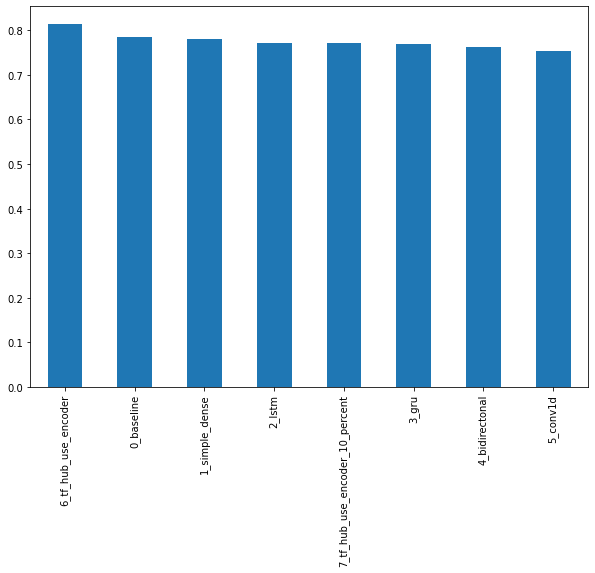

In [99]:
## Sort model results by f1-score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7));

## Uploading our model training logs to TensorBoard.dev

In [ ]:
!tensorboard dev upload --logdir ./model_logs/ \
  --name 'NLP Modelling Experiments' \
  --description 'Comparing multiple types of model architectures on the Kaggle text classification dataset' \
  --one_shot

TensorBoard Experiments: https://tensorboard.dev/experiment/Cal7WOW4RcWgQrmHW69vpA/

In [ ]:
# See the previous TensorBoard Dev experiments you've run...
# !tensorboard dev list

In [ ]:
# If you want to delete an experiment from TensorBoard
# !tensorboard dev delete --experiment_id 'Id'

## Saving and loading a trained model

Save to `HDF5` format...

In [102]:
## Save TF Hub Sentence Encoder model to HDF5 format
model_6.save('model_6.h5')

In [105]:
## Load model with custom Hub layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model('model_6.h5',
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [106]:
## Evaluate loaded model in HDF5 format
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4280 - accuracy: 0.8150


[0.4279668629169464, 0.8149606585502625]

Save to `SavedModel` format...

In [108]:
## Save TF Hub Sentence Encoder model to SavedModel format
model_6.save('model_6_SavedModel_format')

In [109]:
## Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model('model_6_SavedModel_format')

In [110]:
## Evaluate loaded model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4280 - accuracy: 0.8150


[0.4279668629169464, 0.8149606585502625]

## Finding the most wrong examples

In [111]:
## Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2022-11-08 19:45:37--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  31.7MB/s    in 34s     

2022-11-08 19:46:11 (27.3 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variable

In [112]:
## Import downloaded trained model from  Google Storage
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [116]:
## Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)

## Convert predictions into labels
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 0s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [117]:
## Create a DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_pretrained_preds,
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [118]:
## Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10]   # these are false-positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [119]:
most_wrong.tail()   # these are false-negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


target labels...
* `0` = not disaster
* `1` = disaster

In [120]:
## Check the false-prositives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.8148158192634583
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

In [121]:
## Check the false-prositives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507582053542137
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

In [122]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making Predictions on the test dataset and visualizing them

In [ ]:
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

## Challenge... predicting Tweets from the wild

* Go to Twitter and copy one of their latest Tweets
* Pass that Tweet through our trained model
* Is that Tweet a disaster or not disaster? Is the model right or wrong?

In [130]:
tweet = "Asia's deadly month 151 dead during Halloween stampede in Seoul 98 dead in the wake of Typhoon Paeng in the Philippines 132 dead after bridge collapse in India 36 people killed, including 24 children, by ex-cop in Thailand 14 children dead in boat sinking in Cambodia"
pred_prob = tf.squeeze(model_6_pretrained.predict([tweet]))
pred = tf.round(pred_prob)
print(f"Pred: {int(pred)}, Prob: {pred_prob}")
print(f"Text: \n{tweet}\n")

1/1 [==============================] - 0s 37ms/step
Pred: 1, Prob: 0.9956608414649963
Text: 
Asia's deadly month 151 dead during Halloween stampede in Seoul 98 dead in the wake of Typhoon Paeng in the Philippines 132 dead after bridge collapse in India 36 people killed, including 24 children, by ex-cop in Thailand 14 children dead in boat sinking in Cambodia



## The speed/score tradeoff

In [131]:
## Create a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [132]:
## Calculate TF Hub Sentence Encoder time per predictions
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 10ms/step


(0.3479387510005836, 0.0004566125341215008)

In [133]:
## Calculate the baseline model time per predictions
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.02245044999926904, 2.9462532807439685e-05)

In [134]:
# Get results for pretrained model
model_6_pretrained_results = calculate_results(val_labels, model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

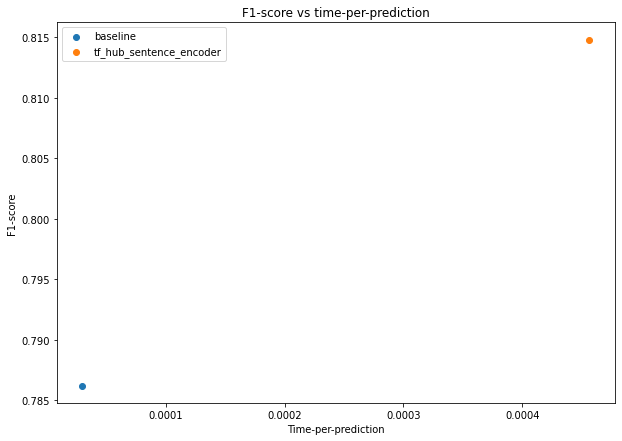

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_sentence_encoder')
plt.legend()
plt.title('F1-score vs time-per-prediction')
plt.xlabel('Time-per-prediction')
plt.ylabel('F1-score');